In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import ResidualsPlot

In [2]:
# import csv, some clean up
wiki_feat = pd.read_csv('../ExtractClean/wiki_10feat.csv')
wiki_feat = wiki_feat.set_index('article_name') #set article name as index

wiki_nlp = pd.read_csv('../NLP/wiki_nlp.csv')
wiki_nlp = wiki_nlp.rename(columns={'this_article_unique_name': 'article_name'})
wiki_nlp.drop(columns=['Unnamed: 0'], inplace=True)
wiki_nlp = wiki_nlp.set_index('article_name') #set article name as index
wiki_nlp = wiki_nlp.reset_index()
wiki_nlp.fillna(value = 0, inplace=True)

In [3]:
# clean up wiki_feat more
wiki_feat.drop(columns=['date_article_creation'], inplace=True, errors='ignore')
cols = wiki_feat.columns.tolist()
wiki_feat_columns = ['languages', 'references', 'text_length', 'main_article_num', 'see_also_num', 'table_text_len', 'sports', 'wiki_link_num', 'days_since_creation']
wiki_feat = wiki_feat.reindex(columns=wiki_feat_columns)
wiki_feat = wiki_feat.reset_index()
wiki_feat = wiki_feat.rename(columns={'languages': 'lang_total_num_targt','references': 'ref_total_num_feat','sports':'sports_bool'})
wiki_feat.drop(columns=['level_0'], inplace=True, errors='ignore')

# clean up wiki_nlp more
wiki_nlp.drop(columns=['level_0'], inplace=True, errors='ignore')

In [4]:
wiki_comb = wiki_feat.merge(wiki_nlp, left_on='article_name', right_on='article_name')
wiki_comb = wiki_comb.reset_index()
wiki_comb.set_index('article_name', inplace=True) #set article name as index
wiki_comb.drop(['1858', 'Ice','Dysprosium','Eucalyptus','.uy','2000s in music'], inplace=True, errors='ignore') #outliers 

In [5]:
# add interacting terms from the terms that were kept from lasso transformation with only the 10 features
wiki_comb['ref_total_num_feat^2'] = wiki_comb['ref_total_num_feat']**2
wiki_comb['sports_bool^2'] = wiki_comb['sports_bool']**2
wiki_comb['see_also_num * sports_bool'] = wiki_comb['sports_bool'] * wiki_comb['see_also_num']
wiki_comb = wiki_comb.reset_index()
wiki_comb.set_index('article_name', inplace=True) #set article name as index

In [6]:
#normalize all features except languages
normalized_wiki_comb = (wiki_comb - wiki_comb.mean()) / wiki_comb.std()
normalized_wiki_comb['lang_total_num_targt'] = wiki_comb['lang_total_num_targt']
normalized_wiki_comb.dropna(axis='columns',inplace=True)

In [7]:
# wiki_comb.loc[wiki_comb['article_name'] == 'Miami Hurricanes football']
# wiki_comb.iloc[45]
normalized_wiki_comb.head()

,level_0,lang_total_num_targt,ref_total_num_feat,text_length,main_article_num,see_also_num,table_text_len,sports_bool,wiki_link_num,days_since_creation,...,calcutta,kmc,bahrenborstel,diepholz,redmond,biologist,obe,ref_total_num_feat^2,sports_bool^2,see_also_num * sports_bool
article_name,,,,,,,,,,,,,,,,,,,,,
"Sérgio Pinto (footballer, born 1973)",-1.732288,1,-0.212821,-0.352448,-0.111103,-0.120394,-0.314144,2.870889,0.109592,0.421800,...,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.055379,2.870889,-0.045402
Bradley Jennings,-1.731335,2,-0.003722,-0.297816,-0.111103,-0.120394,-0.229158,2.870889,-0.343437,-0.543322,...,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.048974,2.870889,-0.045402
Progressive Canadian Party,-1.730382,1,-0.212821,0.622596,-0.111103,2.269721,0.517745,-0.348228,0.158131,1.481108,...,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.055379,-0.348228,-0.045402
2-Heptanone,-1.729430,11,0.623574,0.083659,-0.111103,-0.120394,-0.154376,-0.348228,-0.036024,0.674127,...,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.004135,-0.348228,-0.045402
Michael Yano,-1.728477,20,-0.282520,-0.399591,-0.111103,-0.120394,-0.269214,2.870889,0.174310,0.189240,...,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.016591,-0.056566,2.870889,-0.045402


In [8]:
# Create an empty model
lr_full = LinearRegression()

# Features
X = normalized_wiki_comb.loc[:, 'ref_total_num_feat':"see_also_num * sports_bool"]

# Target
y = normalized_wiki_comb['lang_total_num_targt']

In [15]:
# Fit  
lr_full.fit(X, y)

# Score
lr_full.score(X, y)

0.9998182286019155

In [10]:
# model = LassoCV()
# model.fit(X, y)
# model.alpha_

0.08436010925301002

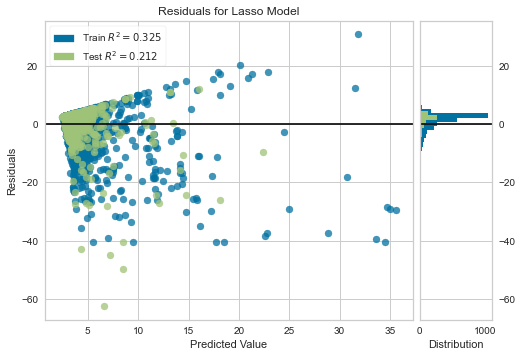

In [9]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate the linear model and visualizer
model = Lasso(alpha=0.84)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
# get the coefficients for the lasso transform to see which terms are left
visualizer.coef_
p.get_feature_names(normalized_wiki_feat.columns)
coef_len = len(visualizer.coef_)

coef_dict = {}
for i in range(len(visualizer.coef_)):
    key = p.get_feature_names(normalized_wiki_feat.columns)[i]
    value = visualizer.coef_[i]
    if value != 0:
        coef_dict[key] = value
coef_dict

In [17]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)
residual = y_test - prediction

residual.sort_values(ascending=False).tail(20)

article_name
Flora of Western Australia                             -7.110489
Seer stone (Latter Day Saints)                         -7.152618
List of Tamil-language television channels             -7.284085
2019 Colorado Springs Switchbacks FC season            -7.567603
2011–12 C.F. Pachuca season                            -7.655947
Northern Branch                                        -7.967985
List of dragonflies (Macromiidae)                      -7.992341
List of dams and reservoirs in Australia               -8.697929
Timeline of Kassel                                     -8.902614
2008 Copa Libertadores knockout stages                 -8.908586
List of people on the postage stamps of Switzerland    -9.687332
Cannabis in Italy                                     -11.368375
2012 in hip hop music                                 -11.453693
Foreign relations of Croatia                          -12.032267
When the Saints Go Marching In (sports anthem)        -12.923380
Presidency o

In [10]:
diff_list = []
scores = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = Lasso(alpha = 0.84)

    model.fit(X_train, y_train)  
    train_score = model.score(X_train, y_train)  
    test_score = model.score(X_test, y_test)
    diff = train_score - test_score
    
    scores.append(train_score)
    diff_list.append(diff)
print(diff_list)

[0.14490502732674249, 0.14083021826181819, 0.17622651474075546, 0.17744159593963538, 0.10558623694712055, 0.17823316078134777, 0.14923632097993544, 0.1866931144986378, 0.09634329162448174, 0.06545010223548298, 0.07623250667949, 0.1138174983250353, 0.14236308076064363, 0.09165449449536978, 0.14979206651603427, 0.08458259525432132, 0.07545856683306207, 0.16430850293720045, 0.12567120557872802, 0.11876766455312171, 0.11637738637745998, 0.09989554082564067, 0.14086706939002347, 0.07921400364704112, 0.15682835304051168, 0.136608228546785, 0.08340664545646581, 0.1908898730291837, 0.16199676407595953, 0.1494424585647235, 0.1820640255090865, 0.10325471756965199, 0.12176003731324703, 0.11008833399595142, 0.1657360190682724, 0.07753852744700884, 0.08465511437201745, 0.13235598496016987, 0.1585571321915048, 0.17951339458751947, 0.20117743264569343, 0.11938004219895171, 0.11895185167151634, 0.16662927835415797, 0.09108182194012882, 0.14790676151694626, 0.1570045089433122, 0.13139023991498777, 0.15

In [11]:
print(sum(diff_list)/100)
print(sum(scores)/100)

0.1350830814241001
0.32828020652528983
